In [1]:
from sklearn.tree import DecisionTreeClassifier
import numpy as np
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold

In [3]:
data = pd.read_csv('./weather.csv') # load a pandas dataframe from csv in current directory
data.head()

,Temperature,Humidity,Wind_Speed,Cloud_Cover,Pressure,Rain
0,23.720338,89.592641,7.335604,50.501694,1032.378759,rain
1,27.879734,46.489704,5.952484,4.990053,992.614190,no rain
2,25.069084,83.072843,1.371992,14.855784,1007.231620,no rain
3,23.622080,74.367758,7.050551,67.255282,982.632013,rain
4,20.591370,96.858822,4.643921,47.676444,980.825142,no rain


In [4]:
df = data
df = df.drop(columns=['Wind_Speed'])
df = df.drop(columns=['Cloud_Cover'])
df.head()

,Temperature,Humidity,Pressure,Rain
0,23.720338,89.592641,1032.378759,rain
1,27.879734,46.489704,992.614190,no rain
2,25.069084,83.072843,1007.231620,no rain
3,23.622080,74.367758,982.632013,rain
4,20.591370,96.858822,980.825142,no rain


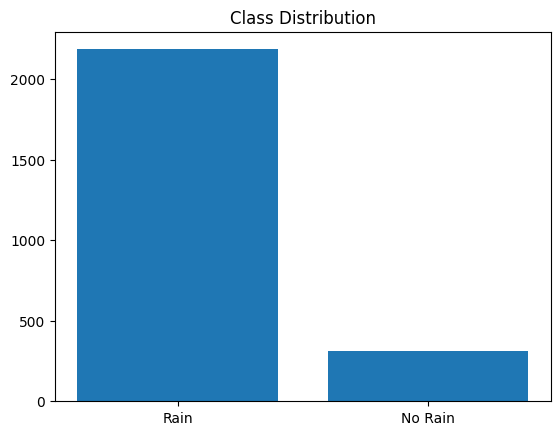

In [5]:
class_counts = df['Rain'].value_counts()  # Replace with your actual counts
labels = ['Rain', 'No Rain']
plt.bar(labels, class_counts)
plt.title('Class Distribution')
plt.show()

In [6]:
# Sélectionner aléatoirement 1700 lignes où 'Rain' est égal à 'no rain'
df_no_rain = df[df['Rain'] == 'no rain'].sample(n=1800, random_state=42)

# Supprimer ces 1700 lignes de 'no rain' du DataFrame original
df_balanced = df.drop(df_no_rain.index)

# Vérification du nouveau nombre de lignes
no_rain_count_balanced = len(df_balanced[df_balanced['Rain'] == 'no rain'])
rain_count_balanced = len(df_balanced[df_balanced['Rain'] == 'rain'])

print(no_rain_count_balanced, rain_count_balanced)

df=df_balanced

386 314


In [7]:
y = df["Rain"]
X = df.drop(columns=['Rain'])

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)
dt = DecisionTreeClassifier(max_leaf_nodes=5, min_samples_leaf=27)
dt.fit(X_train,y_train)
y_predict = dt.predict(X_test)

In [9]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

     no rain       0.96      0.85      0.90       124
        rain       0.84      0.96      0.90       107

    accuracy                           0.90       231
   macro avg       0.90      0.90      0.90       231
weighted avg       0.91      0.90      0.90       231



In [10]:
conf_matrix = confusion_matrix(y_test, y_predict)
print("Contingency table:")
print(pd.DataFrame(
    conf_matrix,
    columns=['Predicted No Rain', 'Predicted Rain'],
    index=['True No Rain', 'True Rain']
))

Contingency table:
              Predicted No Rain  Predicted Rain
True No Rain                105              19
True Rain                     4             103


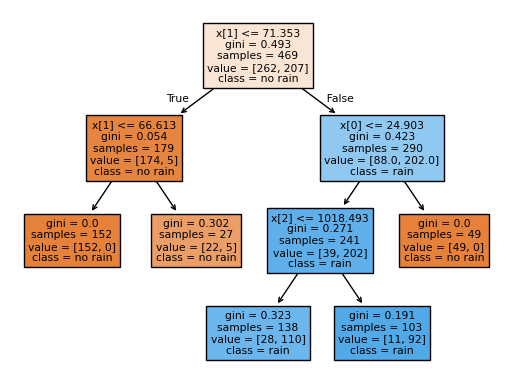

In [11]:
try:
    from sklearn.tree import plot_tree
    _=plot_tree(dt,filled=True,class_names=dt.classes_)
except ImportError:
    pass

In [41]:
cv = StratifiedKFold(n_splits=5, random_state=0, shuffle=True)
scoring = ['accuracy',
           'precision_macro',
           'precision_weighted',
           'recall_macro',
           'recall_weighted',
           'f1_macro',
           'f1_weighted']
scores = cross_validate(dt, X, y, scoring=scoring,
                        cv=cv, return_train_score=True)
scores.keys()
print('Global accuracy over all folds: %0.6f (+/- %0.6f)'
      % (scores['test_accuracy'].mean(), scores['test_accuracy'].std() * 2))
print('For each metric, list the score values on each fold:')
for metric in sorted(scores.keys()):
    print(str(['{:.6f}'.format(value) for value in scores[metric]]) + ' ' +metric)
    

Global accuracy over all folds: 0.908571 (+/- 0.057428)
For each metric, list the score values on each fold:
['0.003503', '0.002505', '0.003963', '0.002516', '0.001997'] fit_time
['0.013060', '0.011519', '0.010577', '0.011033', '0.010512'] score_time
['0.864286', '0.935714', '0.907143', '0.942857', '0.892857'] test_accuracy
['0.864112', '0.935632', '0.907138', '0.942752', '0.892413'] test_f1_macro
['0.863627', '0.935862', '0.907204', '0.942997', '0.893203'] test_f1_weighted
['0.884146', '0.937500', '0.914474', '0.943662', '0.892121'] test_precision_macro
['0.895732', '0.943750', '0.923026', '0.949296', '0.898011'] test_precision_weighted
['0.876623', '0.941558', '0.915584', '0.948052', '0.897229'] test_recall_macro
['0.864286', '0.935714', '0.907143', '0.942857', '0.892857'] test_recall_weighted
['0.925000', '0.908929', '0.916071', '0.907143', '0.907143'] train_accuracy
['0.924939', '0.908914', '0.916039', '0.907132', '0.907085'] train_f1_macro
['0.925161', '0.909032', '0.916210', '0.9

In [42]:
# Test several maximum numbers of leaves
cv = StratifiedKFold(n_splits=50, random_state=0, shuffle=True)
results = {}
for leaves in range(2,40):
    dt = DecisionTreeClassifier(max_leaf_nodes=leaves,criterion="entropy")
    
    local_results = cross_validate(dt, X, y, scoring=["accuracy"],cv=cv, return_train_score=True)
    avg_local_results = pd.DataFrame(local_results).mean()
    results[leaves] = avg_local_results
results_df = pd.DataFrame(results)

Text(0.5, 0, 'Max Nb. Leaves (more complexe models on the right)')

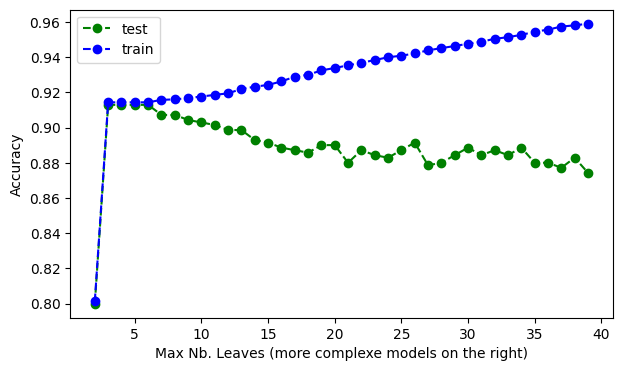

In [43]:
plt.figure(figsize=(7, 4))
plt.plot(results_df.T.index,
         results_df.T["test_accuracy"], "go--", label="test")
plt.plot(results_df.T.index,
         results_df.T["train_accuracy"],"bo--", label="train")
plt.legend()
plt.ylabel("Accuracy")
plt.xlabel("Max Nb. Leaves (more complexe models on the right)")

In [44]:
# Test several minimum leaf size
cv = StratifiedKFold(n_splits=50, random_state=0, shuffle=True)
results = {}
for leaves in range(2,40):
    dt = DecisionTreeClassifier(min_samples_leaf=leaves,criterion="entropy")
    
    local_results = cross_validate(dt, X, y, scoring=["accuracy"],cv=cv, return_train_score=True)
    avg_local_results = pd.DataFrame(local_results).mean()
    results[leaves] = avg_local_results
results_df = pd.DataFrame(results)

Text(0.5, 0, 'Min leaf size (more complex models on the left, overfitting on the left)')

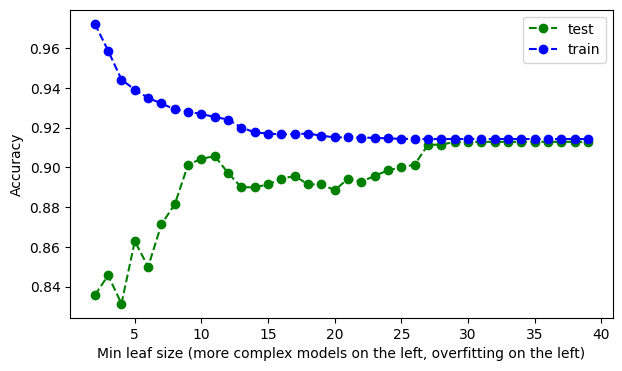

In [45]:
plt.figure(figsize=(7, 4))
plt.plot(results_df.T.index,
         results_df.T["test_accuracy"], "go--", label="test")
plt.plot(results_df.T.index,
         results_df.T["train_accuracy"],"bo--", label="train")
plt.legend()
plt.ylabel("Accuracy")
plt.xlabel("Min leaf size (more complex models on the left, overfitting on the left)")